In [34]:
import pandas as pd
import numpy as np
import mysql.connector

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

In [2]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="tertinggal123"
)
print(mydb)

In [3]:
mycursor = mydb.cursor()
mycursor.execute("Use pijaman_nasabah_dim")
mycursor.execute('select * from fact_data_warehouse')
myresult = mycursor.fetchall()

In [8]:
df = pd.DataFrame(myresult, columns=['cabang', 'Tanggal','idCustomer','statusNikah','jumlahTanggungan', 'pekerjaan', 'gaji','nilaiLoan','terbayar','status'])

In [9]:
df.head()

cabang     Tanggal idCustomer statusNikah jumlahTanggungan pekerjaan  \
0  Pejaten  2022-11-16       C001       Nikah           Sedang       PNS   
1    BlokM  2022-11-16       C002       Nikah           Sedang    Swasta   
2  Pejaten  2022-11-16       C003      Lajang          Sedikit       TNI   

    gaji  nilaiLoan  terbayar status  
0  Besar   75000000  10000000  GAGAL  
1  Besar   60000000  16000000  GAGAL  
2  Besar   45000000   5000000  GAGAL

In [10]:
# kolom yang digunakan, kolom yang mengandung informasi terkait status
df = df[['statusNikah', 'jumlahTanggungan', 'pekerjaan', 'gaji', 'nilaiLoan','terbayar','status']]

In [11]:
df.head()

statusNikah jumlahTanggungan pekerjaan   gaji  nilaiLoan  terbayar status
0       Nikah           Sedang       PNS  Besar   75000000  10000000  GAGAL
1       Nikah           Sedang    Swasta  Besar   60000000  16000000  GAGAL
2      Lajang          Sedikit       TNI  Besar   45000000   5000000  GAGAL

In [13]:
# # Dilakukan penambahan data dikarenakan data sangat sedikit untuk dilakukan proses pelatihan model machine learning
# df.insert(3, "Lajang", "Swasta", "Besar", 50000000, 20000000,'BERHASIL')
df.to_csv('ujianAkir.csv')

In [14]:
df = pd.read_csv('ujianAkir.csv')

In [16]:
df.shape

(120, 7)

In [42]:
# Mengubah data categorical menjadi bentuk numeric
df['statusNikah'].replace(to_replace=['Nikah', 'Lajang'], value=[1, 2], inplace=True)
df['jumlahTanggungan'].replace(to_replace=['Sedang', 'Sedikit'], value=[1, 2], inplace=True)
df['gaji'].replace(to_replace=['Besar'], value=[1], inplace=True)
df['pekerjaan'].replace(to_replace=['Swasta', 'TNI', 'PNS'], value=[1, 2, 3], inplace=True)
df['status'].replace(to_replace=['GAGAL', 'SUKSES'], value=[1, 2], inplace=True)

In [43]:
df.head()

statusNikah  jumlahTanggungan  pekerjaan  gaji  nilaiLoan  terbayar  status
0            1                 1          3     1   75000000  10000000       1
1            1                 1          1     1   60000000  16000000       1
2            2                 2          2     1   45000000   5000000       1
3            2                 2          1     1   45000000  15000000       2
4            2                 2          1     1   45000000  15000000       2

In [22]:
df.jumlahTanggungan.value_counts()

Sedikit    72
Sedang     48
Name: jumlahTanggungan, dtype: int64

In [23]:
df.pekerjaan.value_counts()

Swasta    48
TNI       48
PNS       24
Name: pekerjaan, dtype: int64

In [32]:
df.status.value_counts()

GAGAL     72
SUKSES    48
Name: status, dtype: int64

In [33]:
df.isnull().sum()

statusNikah         0
jumlahTanggungan    0
pekerjaan           0
gaji                0
nilaiLoan           0
terbayar            0
status              0
dtype: int64

In [44]:
X = df[['status', 'jumlahTanggungan', 'pekerjaan', 'gaji', 'nilaiLoan', 'terbayar']]
y = df['status']

In [45]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [46]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>lr 1.000 (0.000)
>knn 1.000 (0.000)
>cart 1.000 (0.000)
>svm 1.000 (0.000)
>bayes 1.000 (0.000)


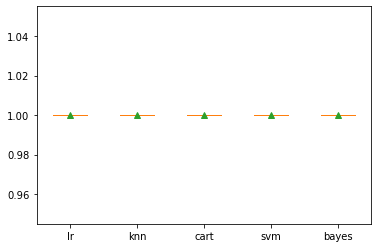

In [47]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [48]:
 #STACKING
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [49]:
def get_modelstacking():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

>lr 1.000 (0.000)
>knn 1.000 (0.000)
>cart 1.000 (0.000)
>svm 1.000 (0.000)
>bayes 1.000 (0.000)
>stacking 1.000 (0.000)


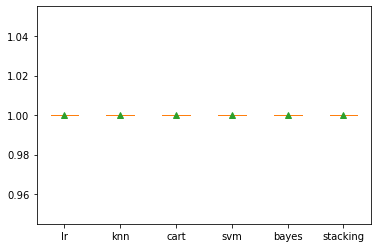

In [51]:
from sklearn.ensemble import StackingClassifier

# evaluate a give model using cross-validation
def evaluate_model_stacking(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_modelstacking()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model_stacking(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()